# Do you know America's top 10 poisonous plants well?
by: Sparkle Russell-Puleri

## Load all of required packages

In [2]:
import sys
sys.path.append('/usr/local/bin/chromedriver')
import glob,os,pathlib
from os import listdir
from PIL import Image
from fastai import *
from fastai.vision import *
np.random.seed(0)
from google_images_download import google_images_download
import scrapy
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 180

Autosaving every 180 seconds


## Check to ensure that the CUDA is available

In [4]:
torch.cuda.is_available()

True

## Scrape web for top 10 poisonous plants in the US

Scraping the web to obtain data on an Ubuntu EC2 instance requires several downloads. During this project I used both the scrapy and selenium packages. However, I decided upon the latter mainly because of easy of use, while I have used scrapy in the past, it primarly works well at the command line. This makes it difficult to pass variables from bash to python when using jupyter notebooks.

In [47]:
# Required for using Chrome driver on Ubuntu
# sudo apt-get install xvfb
# sudo pip install pyvirtualdisplay

In [5]:
# this package is required for use on an Ubuntu system
from pyvirtualdisplay import Display
from selenium import webdriver

display = Display(visible=0, size=(1024, 768))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

This section of code can be easily adapted to a any website of choice, if the h2 tags are known then a simple xpath call to that tag can extract the labels of interest

In [6]:
from selenium import webdriver
import pandas as pd

# Use selenium to scrape the items of interest from the web
web_drv = webdriver.Chrome()
web_drv.get('https://www.worldatlas.com/articles/10-poisonous-plants-found-in-the-united-states.html')
plants = web_drv.find_elements_by_xpath('//h2') # I found this by inspecting the html code for the page and tag of interest

In [7]:
# extract the all of the desired text from the response object using the appropreiate html tag
top_10_poisonous_plants = []
for i,j in enumerate(plants):
     top_10_poisonous_plants.append(plants[i].text)

In [8]:
top_10_poisonous_plants[:10]

['Spotted spurge',
 'Poison Oak',
 'Daffodil',
 'Common Corn-Cockle',
 'Water hemlock',
 'Oleander',
 'Poke berry',
 'Poison Ivy',
 'White hellebore',
 'Deadly Nightshade']

## Getting data
This downloader allows the user to past a list of desired keywords and the number of images requested to the google image downloader. This will return individual folders with images for each of the requested classes.

In [ ]:
def images(list_of_names, num_images):
    response = google_images_download.googleimagesdownload()
    arguments = {"keywords":",".join(list_of_names),"limit":num_images,
                 "print_urls":True, "related_images":False}   #creating list of arguments
    paths = response.download(arguments)   #passing the arguments to the function
    print(paths)   #printing absolute paths of the downloaded images

In [ ]:
# Call image downloading function
images(top_10_poisonous_plants[:10],100)

## Defining file paths
The google downloader will download the desired images to downloads folder by default unless a download directory is explicitly provided

In [9]:
PATH = Path(os.path.join(os.getcwd(), 'downloads'))
# PATH = Path(os.path.join(os.getcwd(), 'data2'))

In [10]:
PATH.ls()[:2]

[PosixPath("/home/ubuntu/course-v3/nbs/dl1/Sparkle's Projects/Image Classifier/Poisonous Plants/downloads/train"),
 PosixPath("/home/ubuntu/course-v3/nbs/dl1/Sparkle's Projects/Image Classifier/Poisonous Plants/downloads/Oleander")]

In [11]:
path_img = PATH

## Image processing and quality checks
The images downloaded from google are downloaded with the tags that can sometimes look a bit weird. Therefore, I created this function to programmatically rename the files to the directory name with numeric indices.

In [ ]:
# Rename each image using the directory(optional--I personally do not like images with weird hash like names)
import os
def rename(list_of_items):
    for plant in list_of_items[:10]:
        plant_folder = 'downloads/'+ plant
        path  = os.path.join(os.getcwd(),plant_folder)
        
        i = 0
        for filename in os.listdir(path):
            os.rename(os.path.join(path,filename), os.path.join(path,plant + str(i) +'.jpg'))
            i = i +1
        print('Renamed all images in ....{} folder'.format(plant))

In [ ]:
rename(top_10_poisonous_plants) # rename all of the files to match the name of it's respective directory

## Remove corrupt images
The google downloader does well to catch corrupt files, some still existed in the folders. This function cleans up all remaining corrupt files.

In [ ]:
def remove_corrupt_images(file_path):
    from os import listdir
    from PIL import Image
    directories = [f for f in os.listdir(file_path) if f not in ['.DS_Store','.ipynb_checkpoints']]
    for folder in directories:
        files = file_path/folder
        for i in os.listdir(files):
            try:
                imgs = Image.open(os.path.join(files, i))
                imgs.verify()
            except (OSError,FileNotFoundError):
                print("File {} from folder {} corrupt files...hence removed".format(folder,i))
                os.remove(files/i)           

In [ ]:
remove_corrupt_images(path_img)

# Split files into training and test directories for training
The fast.ai `ImageDataBunch.from_folder` function requires the data to be in a 'Imagenet style' folder structure shown below:

<blockquote>
<p>path\</p>
<pre><code>train\
     class1\
     class2\
     ...
valid\
     clas1\
     clas2\
     ...
test\
</code></pre></blockquote>

This helper function creates a train and validation directory and splits the data into a user defined validation percentage set.


  

In [ ]:
def create_dir(image_path,val_pct):
    directory = [f for f in os.listdir(image_path) if f not in ['.DS_Store','.ipynb_checkpoints']]
    try:
        os.mkdir(image_path/'train')
        os.mkdir(image_path/'valid')
    except FileExistsError:
        print('File already exists')
        pass

    for p in directory:
        try:
            os.mkdir(image_path/'train'/p)
            os.mkdir(image_path/'valid'/p)
        except FileExistsError:
            print('File already exists')
            pass

    for folder in directory:
        dest_dir_1 = image_path/'valid'/folder
        dest_dir_2 = image_path/'train'/folder
        source = image_path/folder
        n = int(len(os.listdir(image_path/folder)))
        n_val = int(n*val_pct)
        train = (os.listdir(image_path/folder))[:n-n_val]
        valid = (os.listdir(image_path/folder))[n-n_val:]
        
        print("There are:{} images in {}".format(n,folder[:10]))

        for i in train:
            paths_train = pathlib.Path(i)
            paths_train.absolute()
            source = image_path/folder/i
            dest_train = image_path/'train'/folder
            shutil.copy2(source,dest_train)

        for i in valid:
            paths_valid = pathlib.Path(i)
            paths_valid.absolute()
            source = path_img/folder/i
            dest_valid = image_path/'valid'/folder
            shutil.copy2(source,dest_valid)

In [ ]:
path_to_files = create_dir(path_img,0.2)
path_to_files

## Creating the data bunch using the `ImageDataBunch.from_folder` approach
If you want to maintain the folder names the ImageDataBunch.from_folder module allows you to quickly get your hands wet and and focus on training the data uisng the 'Imagenet stype' folder structure. If you prefer to rename the files using the image file name. The `ImageDataBunch.from_name_re` approach allows one to use a regex pattern to extract the respective unique file names.

In [12]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path_img,ds_tfms=get_transforms(),size=224)
data.normalize(imagenet_stats)

## Inspect data to get an idea of what was downloaded

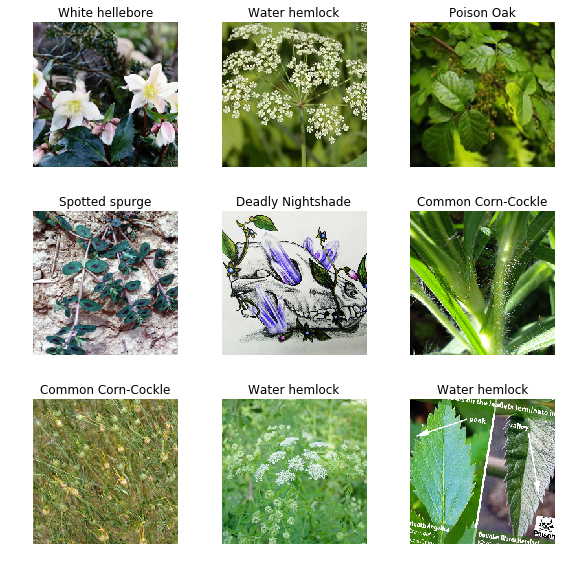

In [13]:
data.show_batch(rows=3,figsize=(8,8))

## Inspect the data classes

In [14]:
print(data.classes)
len(data.classes),data.c

['Common Corn-Cockle', 'Daffodil', 'Deadly Nightshade', 'Oleander', 'Poison Ivy', 'Poison Oak', 'Poke berry', 'Spotted spurge', 'Water hemlock', 'White hellebore']


(10, 10)

## Train the model
This model was trained using the transfer learning approach with a ResNet34 CNN backbone. In this approach the weights of the Resenet34 backbone were frozen with the exception of the final dense layer. Why? The original ResNet34 algorithm was trained on the ImageNet dataset which contains 14,197,122 images and 1000 classes. This  residual net has a depth of up to 152 layers, but despite it's depth this model has a lower complexity (as shown below) than some of the other well known deep learning architectures, which resulted in it nabbing 1st place in the Kaggle  ILSVRC  classification competition in 2015.

<h1>How does the ResNet34 work?</h1>
The ResNet34 was developed to address the degradation challenges that occur with increasing network depth. This is done by creating identity shortcuts or highways that skips one of more layers, thus avoiding the issue of vanishing gradients.

<img src="http://euler.stat.yale.edu/~tba3/stat665/lectures/lec18/img/resNet.jpg">



source[Authors: Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
https://arxiv.org/abs/1512.03385]

# Train and save the model

In [15]:
learn= create_cnn(data, models.resnet34, metrics=error_rate)

In [16]:
learn.fit_one_cycle(5)

Total time: 01:46
epoch  train_loss  valid_loss  error_rate
1      2.206285    1.248084    0.363128    (00:23)
2      1.504528    0.705709    0.229050    (00:20)
3      1.117175    0.598252    0.212290    (00:21)
4      0.868539    0.583451    0.206704    (00:20)
5      0.721154    0.589517    0.223464    (00:19)



In [21]:
learn.save('Pre-optimized-1')
learn.load('Pre-optimized-1')

# Model interpretation
After training the model I investigated the classes that the model seemed to be most confused with. Here we can see that the model incorrectly classified images that were clearly were either low resolution or too far away to corretly identify local patterns. One important observation that can be seen by the confusion matrix is the confusion between `Posion Ivy` and `Posion Oak`. This is not suprising after further inspecting what they both look like, it is clear that both of these plants have very similar leaf structures as shown below. Despite this I was able to achieve 78% accuracy.

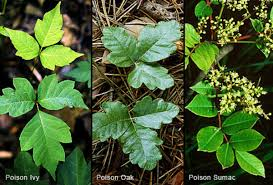

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

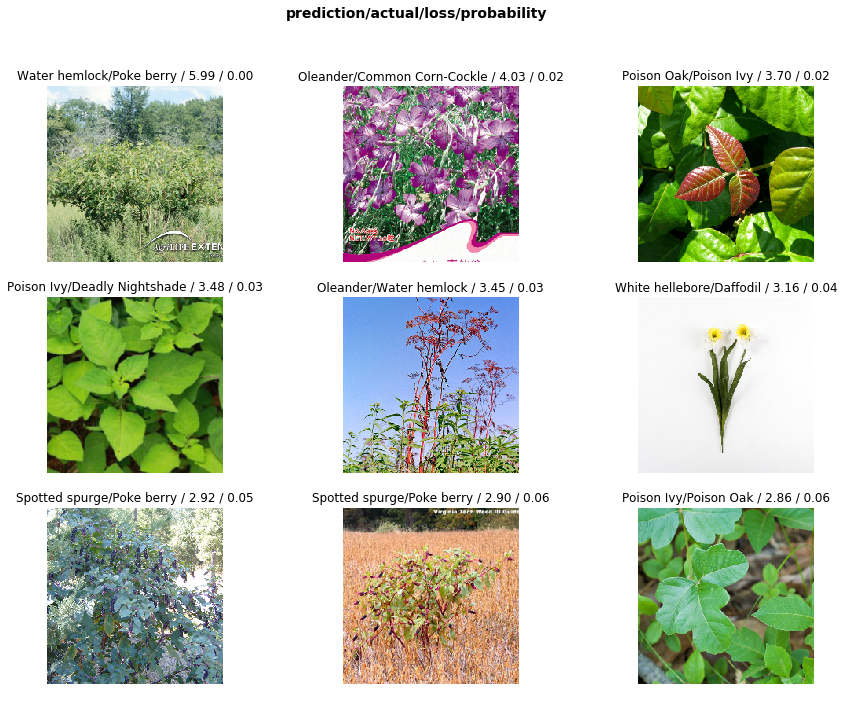

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

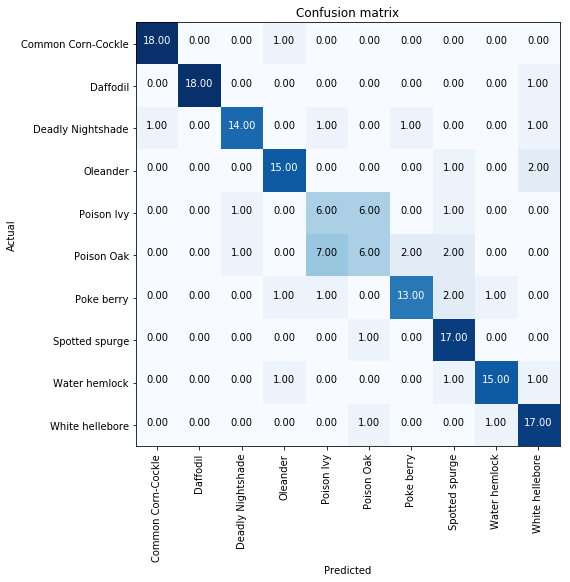

In [19]:
interp.plot_confusion_matrix(figsize=(10,8))

## Fine Tuning the model
After looking confirming that the classes that the model got wrong were resonable. I unfreezed the model to try and optimize it a bit more. This was done using the learning rate finder module `lr_find` to find the optimal learning rate. The `reorder.plot` provides a visual representation of the the learning rates tested. The idea here is to find the region of the graph where the slopr of the loss curve is the steepest but exhibits the steady reduction. To identify the optimal value the `max_lr` parameter of the `fit_one_cycle` method. After 2 epocs the validation loss is much higher than the training loss, which is means that the learning rate is currently too high.
FYI...3-e4 was selected since it has consistently shown favorable results empircally.

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


In [22]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

Total time: 00:43
epoch  train_loss  valid_loss  error_rate
1      0.427328    0.575651    0.195531    (00:22)
2      0.344376    0.562919    0.184358    (00:20)



In [ ]:
learn.save('Pre-optimized-2')

# Re-Inspecting images for inappropriate downlods
The images were re-inspected using the fast.ai widget developed by my fellow course mates of the San Francisco study group. Using the `FileDeleter` widget images that are obviously not well suited for the task. After re-training my final accuarcy was:

In [ ]:
learn.load('Pre-optimized-2')

In [23]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

## Remove odd images that may have snuck through

In [24]:
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

# Re-train model on cleaned up data set
After cleaning up the images by removing irrelevant images, the model was retrained. Here you can see that there was a slight improvement in accuary to 83%.

In [25]:
data2 = ImageDataBunch.from_folder(path_img,ds_tfms=get_transforms(),size=224)
data2.normalize(imagenet_stats)
learn2 = create_cnn(data2,models.resnet34,metrics=error_rate)
learn.load('Pre-optimized-2')

In [26]:
learn2.fit_one_cycle(5)

Total time: 01:44
epoch  train_loss  valid_loss  error_rate
1      2.174109    1.226970    0.363128    (00:20)
2      1.473221    0.677903    0.206704    (00:20)
3      1.075505    0.598932    0.184358    (00:20)
4      0.863522    0.555610    0.167598    (00:21)
5      0.716710    0.558414    0.178771    (00:21)



## Finally testing the model in the wild

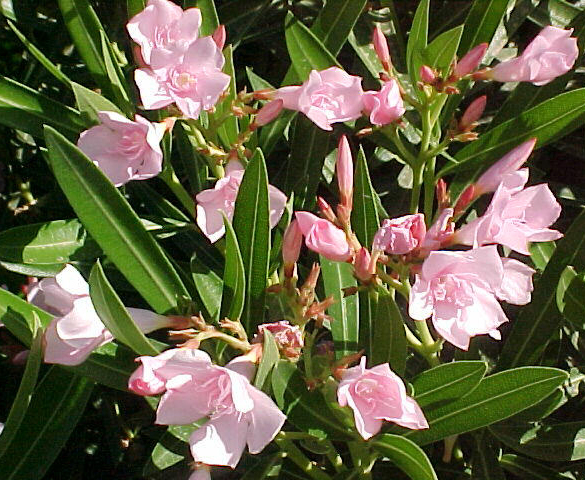

In [32]:
img = open_image(PATH/'test_oleander.jpg')
img

## Model prediction

In [33]:
pred_class,pred_idx,outputs = learn2.predict(img)
pred_class

'Oleander'

In [ ]:
learn2.save('Final_poisonous_plants_model')

# Summary
While this is not a perfect model it demonstrates how easy it is to train a deep learning algorithm using the fastai package and achieve 83%. This is still in the beta stage, I plan on continuing to find ways to enhance the model...

## The end 😊!!